In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet1 = pd.read_excel('data_input/WTI_映射残差_EIA去库幅度_non_trend.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet1 = sheet1.set_index('Date')
sheet = sheet1[['WTI连1-连4月差','EIA能源月报统计美国原油去库幅度/3MMA']].copy()
sheet.tail()

,WTI连1-连4月差,EIA能源月报统计美国原油去库幅度/3MMA
Date,,
2026-08-31,NaN,0.0098
2026-09-30,NaN,0.0201
2026-10-31,NaN,0.1615
2026-11-30,NaN,0.1653
2026-12-31,NaN,0.3016


In [5]:
sheet = sheet.asfreq('B')
sheet.columns

Index(['WTI连1-连4月差', 'EIA能源月报统计美国原油去库幅度/3MMA'], dtype='object')

In [6]:

#################################  因子处理  #################################
sheet['WTI连1-连4月差_提前24周'] = sheet['WTI连1-连4月差'].shift(120)

last_day = sheet['WTI连1-连4月差_提前24周'].last_valid_index()
################################# 处理缺失值 #################################
# 使用3阶样条插值法进行平滑填充
sheet['EIA能源月报统计美国原油去库幅度/3MMA'] = sheet['EIA能源月报统计美国原油去库幅度/3MMA'].interpolate(method='cubic', order=3)
sheet.loc[:last_day, 'WTI连1-连4月差_提前24周'] = sheet.loc[:last_day, 'WTI连1-连4月差_提前24周'].interpolate(method='linear')

################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])
sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-11')]



sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['WTI连1-连4月差_提前24周'].notna())
]

################################# 数据 读取-处理 结束 #################################

In [7]:
# 对WTI连1-连4月差_提前24周进行3个月移动平均平滑处理
sheet_daily.loc[sheet_daily['WTI连1-连4月差_提前24周'].notna(), 'WTI连1-连4月差_提前24周'] = sheet_daily.loc[sheet_daily['WTI连1-连4月差_提前24周'].notna(), 'WTI连1-连4月差_提前24周'].rolling(window=20, min_periods=1).mean()
sheet_daily

,Date,WTI连1-连4月差,EIA能源月报统计美国原油去库幅度/3MMA,WTI连1-连4月差_提前24周
0,2023-01-11,-0.63,0.238244,4.920000
1,2023-01-12,-0.61,0.230718,4.715000
2,2023-01-13,-0.52,0.223006,4.726667
3,2023-01-16,NaN,0.198684,4.445000
4,2023-01-17,-0.53,0.190161,4.174000
...,...,...,...,...
1032,2026-12-25,NaN,0.276098,NaN
1033,2026-12-28,NaN,0.288983,NaN
1034,2026-12-29,NaN,0.293221,NaN
1035,2026-12-30,NaN,0.297427,NaN


In [8]:
last_day

Timestamp('2025-10-30 00:00:00')

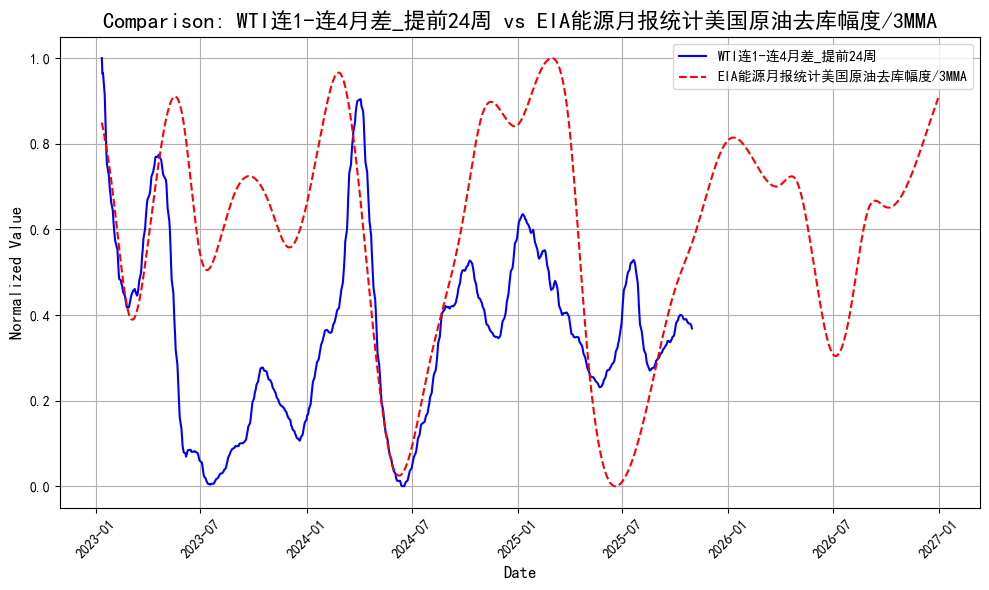

In [9]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='WTI连1-连4月差_提前24周', 
    compare_cols=[
        'EIA能源月报统计美国原油去库幅度/3MMA'
        ]
)

In [10]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 1
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        'EIA能源月报统计美国原油去库幅度/3MMA'
]

predict_column = 'WTI连1-连4月差_提前24周'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

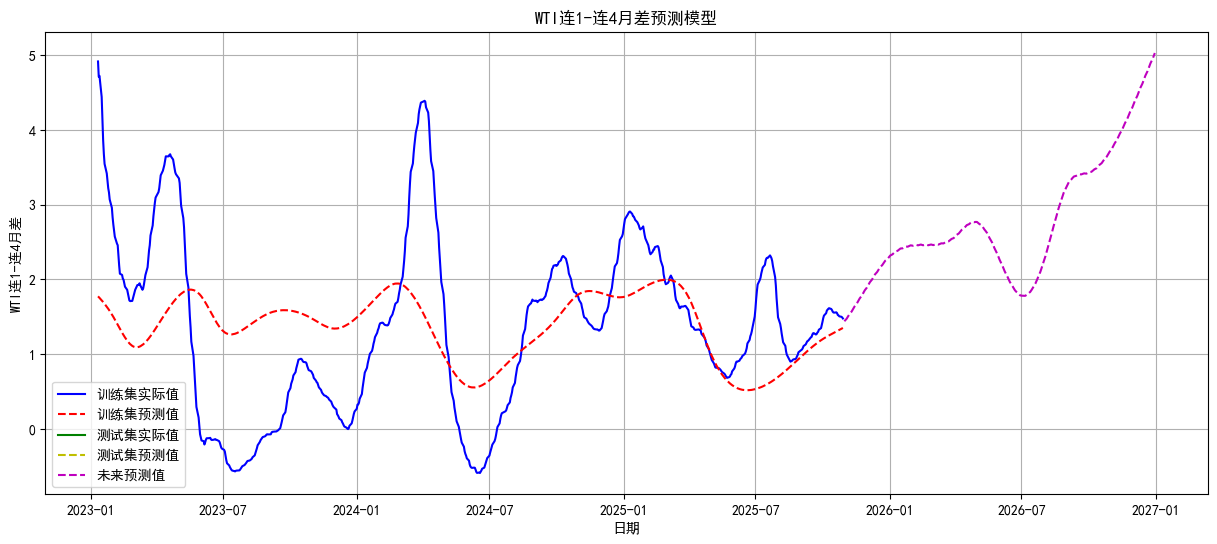

In [11]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt



# 定义一个函数来增加斜率
def increase_slope(predictions, slope_factor=1.5):
    if len(predictions) <= 1:
        return predictions
    start_value = predictions[0]
    x = np.arange(len(predictions))
    original_slope, original_intercept = np.polyfit(x, predictions, 1)
    new_slope = original_slope * slope_factor
    new_intercept = start_value
    steepened_predictions = new_intercept + new_slope * x
    return steepened_predictions


# 1. 数据准备和标准化
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
X_future_scaled = scaler_X.transform(X_future)
# 2. 模型训练
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)
best_model = model

# 3. 预测
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)
future_pred = best_model.predict(X_future_scaled)
future_pred_steepened = increase_slope(future_pred, slope_factor=-20.0)  # 调整slope_factor来控制斜率增加程度
future_data.loc[:, '预测值_全量'] = future_pred_steepened *future_pred
#future_data.loc[:, '预测值_全量'] = future_pred
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
# 4. 简化的可视化展示
plt.figure(figsize=(15, 6))
plt.plot(train_data['Date'], y_train, 'b-', label='训练集实际值')
plt.plot(train_data['Date'], y_train_pred, 'r--', label='训练集预测值')
plt.plot(test_data['Date'], y_test, 'g-', label='测试集实际值')
plt.plot(test_data['Date'], y_test_pred, 'y--', label='测试集预测值')
plt.plot(future_data['Date'], future_data['预测值_全量'], 'm--', label='未来预测值')
plt.title('WTI连1-连4月差预测模型')
plt.xlabel('日期')
plt.ylabel('WTI连1-连4月差')
plt.legend()
plt.grid(True)
plt.show()

# 5. 保存预测结果
result_df = pd.DataFrame({
    'Date': future_data['Date'],
    'EIA能源月报统计美国原油去库幅度/3MMA': future_data['EIA能源月报统计美国原油去库幅度/3MMA'],
    'Predicted_WTI连1-连4月差': future_data['预测值_全量']
})

In [12]:
result_df 

,Date,EIA能源月报统计美国原油去库幅度/3MMA,Predicted_WTI连1-连4月差
732,2025-10-31,-0.070300,1.440500
733,2025-11-03,-0.056828,1.472114
734,2025-11-04,-0.052188,1.487736
735,2025-11-05,-0.047480,1.503546
736,2025-11-06,-0.042709,1.519537
...,...,...,...
1032,2026-12-25,0.276098,4.895481
1033,2026-12-28,0.288983,4.955059
1034,2026-12-29,0.293221,4.981093
1035,2026-12-30,0.297427,5.007061


In [13]:
sheet_daily

,Date,WTI连1-连4月差,EIA能源月报统计美国原油去库幅度/3MMA,WTI连1-连4月差_提前24周
0,2023-01-11,-0.63,0.238244,4.920000
1,2023-01-12,-0.61,0.230718,4.715000
2,2023-01-13,-0.52,0.223006,4.726667
3,2023-01-16,NaN,0.198684,4.445000
4,2023-01-17,-0.53,0.190161,4.174000
...,...,...,...,...
1032,2026-12-25,NaN,0.276098,NaN
1033,2026-12-28,NaN,0.288983,NaN
1034,2026-12-29,NaN,0.293221,NaN
1035,2026-12-30,NaN,0.297427,NaN


In [14]:
# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    result_df[['Date','Predicted_WTI连1-连4月差']],
    on='Date',
    how='left'
)
sheet_daily['WTI连1-连4月差_提前24周'] = sheet_daily['WTI连1-连4月差_提前24周'].fillna(sheet_daily['Predicted_WTI连1-连4月差'])
sheet_daily = sheet_daily.drop(columns=['Predicted_WTI连1-连4月差'])

In [15]:
sheet_daily

,Date,WTI连1-连4月差,EIA能源月报统计美国原油去库幅度/3MMA,WTI连1-连4月差_提前24周
0,2023-01-11,-0.63,0.238244,4.920000
1,2023-01-12,-0.61,0.230718,4.715000
2,2023-01-13,-0.52,0.223006,4.726667
3,2023-01-16,NaN,0.198684,4.445000
4,2023-01-17,-0.53,0.190161,4.174000
...,...,...,...,...
1032,2026-12-25,NaN,0.276098,4.895481
1033,2026-12-28,NaN,0.288983,4.955059
1034,2026-12-29,NaN,0.293221,4.981093
1035,2026-12-30,NaN,0.297427,5.007061


In [16]:
sheet1 = sheet1.copy()
sheet1.index.name = 'Date'
sheet1 = sheet1.reset_index()
sheet_daily_1 = pd.merge(
    sheet_daily[['Date','WTI连1-连4月差_提前24周']],
    sheet1[['Date','WTI原油期货价格/月度/3MMA映射残差/EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年（领先2月）Non-Trend/F0.5']],
    on='Date',
    how='left'
)
# 找到最后一个非空值的日期
last_valid_date = sheet_daily_1[sheet_daily_1['WTI原油期货价格/月度/3MMA映射残差/EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年（领先2月）Non-Trend/F0.5'].notna()]['Date'].max()
sheet_daily_1['WTI原油期货价格/月度/3MMA映射残差/EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年（领先2月）Non-Trend/F0.5'] = sheet_daily_1['WTI原油期货价格/月度/3MMA映射残差/EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年（领先2月）Non-Trend/F0.5'].interpolate(method='cubic', order=3)
sheet_daily_1['WTI连1-连4月差_落后20周'] = sheet_daily_1['WTI连1-连4月差_提前24周'].shift(-100)
sheet_daily_1 = sheet_daily_1[(sheet_daily_1['Date'] > last_valid_date) | (sheet_daily_1['WTI原油期货价格/月度/3MMA映射残差/EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年（领先2月）Non-Trend/F0.5'].notna())]
sheet_daily_1 = sheet_daily_1.dropna(subset=['WTI连1-连4月差_落后20周'])
# 获取last_valid_date后90天的数据
last_valid_date_plus_90 = pd.to_datetime(last_valid_date) + pd.Timedelta(days=90)
sheet_daily_1 = sheet_daily_1[sheet_daily_1['Date'] <= last_valid_date_plus_90]


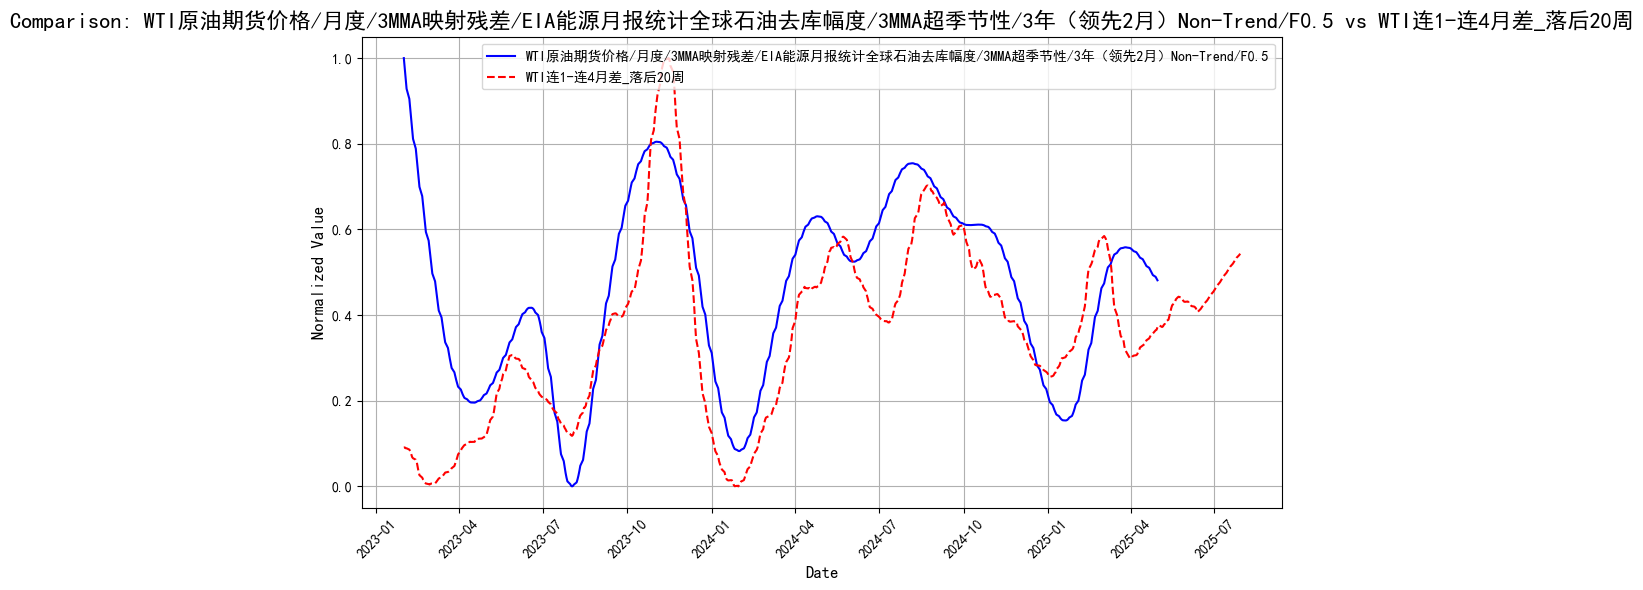

In [17]:
sheet_daily_plot1 = sheet_daily_1.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot1, 
    main_col='WTI原油期货价格/月度/3MMA映射残差/EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年（领先2月）Non-Trend/F0.5', 
    compare_cols=[ 
        'WTI连1-连4月差_落后20周'
        ]
)

In [18]:
sheet_daily_1

,Date,WTI连1-连4月差_提前24周,WTI原油期货价格/月度/3MMA映射残差/EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年（领先2月）Non-Trend/F0.5,WTI连1-连4月差_落后20周
14,2023-01-31,2.832667,7.978800,-0.141250
15,2023-02-01,2.735000,7.628180,-0.139250
16,2023-02-02,2.657647,7.278776,-0.148750
17,2023-02-03,2.574444,6.930813,-0.149750
18,2023-02-06,2.480000,6.584513,-0.164750
...,...,...,...,...
660,2025-07-23,2.284500,NaN,2.033232
661,2025-07-24,2.246000,NaN,2.050273
662,2025-07-25,2.180500,NaN,2.067190
663,2025-07-28,2.031000,NaN,2.100030


In [19]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data1 = sheet_daily_1[sheet_daily_1['Date'] <= last_valid_date].copy()
test_period1 = 66
test_data1 = train_data1[-test_period1:].copy() 
train_data1 = train_data1[:-test_period1].copy()
future_data1 = sheet_daily_1[sheet_daily_1['Date'] > last_valid_date].copy()

feature_columns1 = [
    'WTI连1-连4月差_落后20周'
]

predict_column1 = 'WTI原油期货价格/月度/3MMA映射残差/EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年（领先2月）Non-Trend/F0.5'

X_train1 = train_data1[feature_columns1]
y_train1 = train_data1[predict_column1]

X_test1 = test_data1[feature_columns1]
y_test1 = test_data1[predict_column1]

X_future1 = future_data1[feature_columns1]

In [38]:
# 训练模型
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
model = LinearRegression()
X_train1 = train_data1[feature_columns1].values.reshape(-1, 1)
y_train1 = train_data1[predict_column1].values
model.fit(X_train1, y_train1)

# 在测试集上评估模型
X_test1 = test_data1[feature_columns1].values.reshape(-1, 1)
y_test1 = test_data1[predict_column1].values
y_pred_test1 = model.predict(X_test1)
y_pred_train1 = model.predict(X_train1)
# 计算评估指标
mse = mean_squared_error(y_test1, y_pred_test1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, y_pred_test1)
r2 = r2_score(y_test1, y_pred_test1) # 修改这里,使用y_test1而不是y_test

print('模型评估指标:')
print(f'均方误差 (MSE): {mse:.6f}')
print(f'均方根误差 (RMSE): {rmse:.6f}')
print(f'平均绝对误差 (MAE): {mae:.6f}')
print(f'R2分数: {r2:.6f}')

# 对未来数据进行预测
X_future1 = future_data1[feature_columns1].values.reshape(-1, 1)
future_predictions1 = model.predict(X_future1)
future_data1['预测值_全量'] = future_predictions1
train_data1['预测值'] = y_pred_train1
test_data1['预测值'] = y_pred_test1


future_pred_steepened1 = increase_slope(future_predictions1, slope_factor=1.8)  # 调整slope_factor来控制斜率增加程度
future_data1.loc[:, '预测值_全量'] = future_pred_steepened1 *future_predictions1

模型评估指标:
均方误差 (MSE): 5.267185
均方根误差 (RMSE): 2.295035
平均绝对误差 (MAE): 1.957277
R2分数: -0.734590


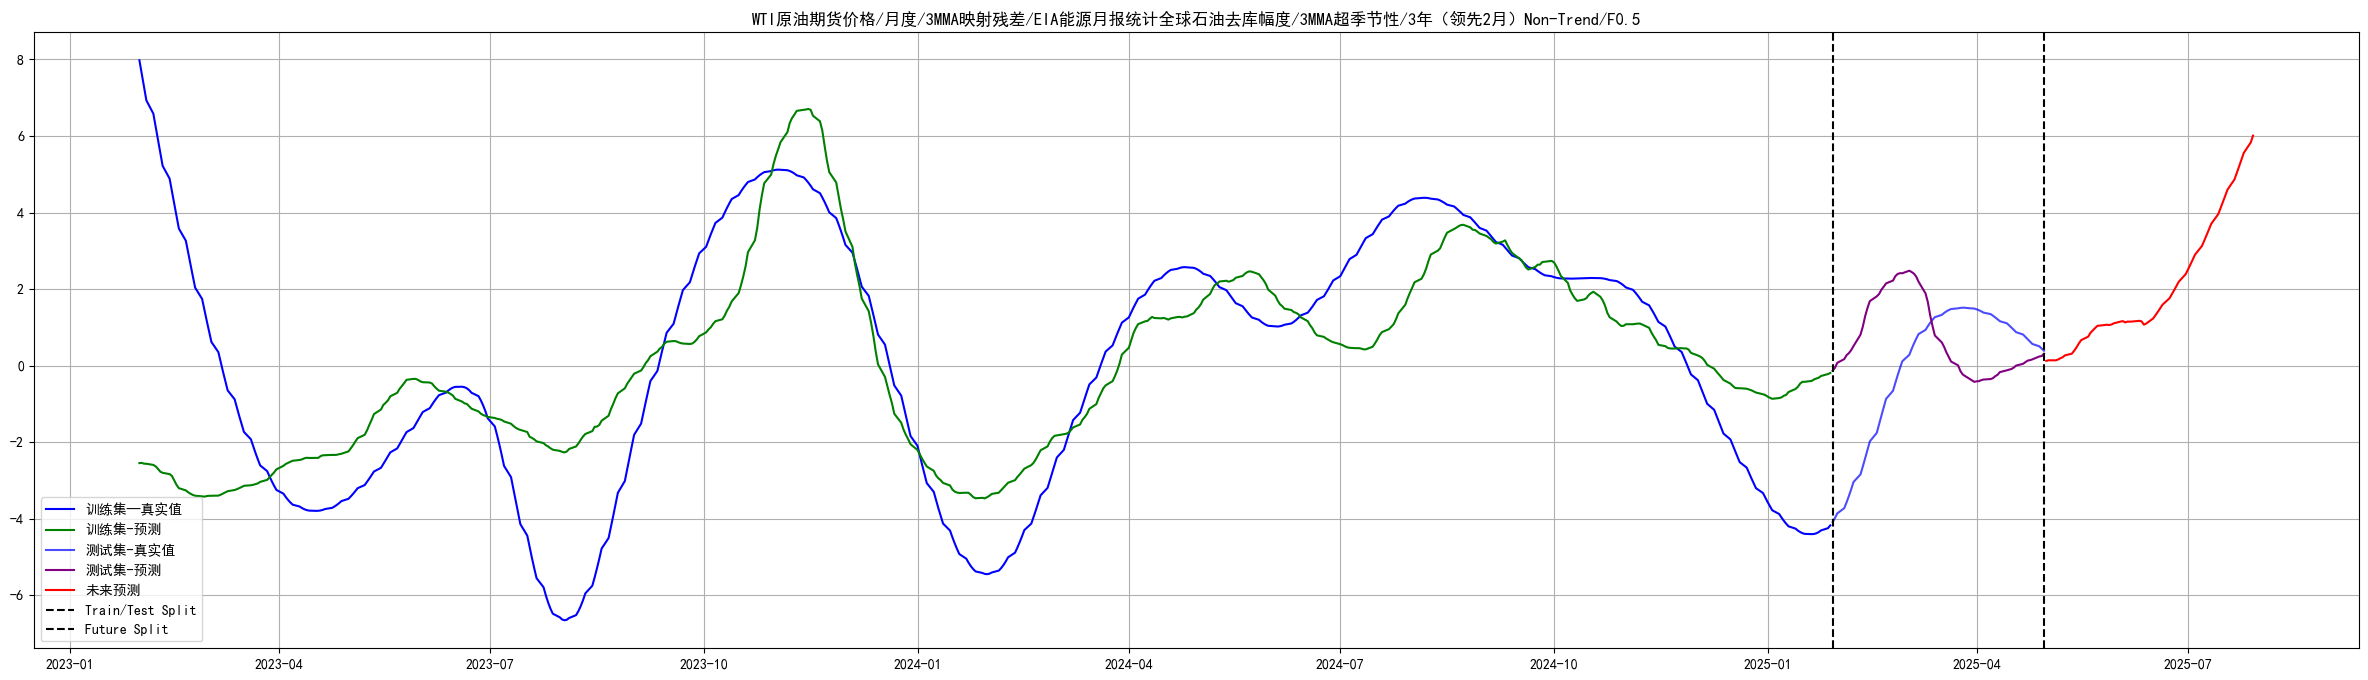

In [39]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
plt.plot(train_data1['Date'], y_train1, label='训练集—真实值', color='blue')
plt.plot(train_data1['Date'],y_pred_train1, label='训练集-预测', color='green')
plt.plot(test_data1['Date'], y_test1, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data1['Date'],  y_pred_test1, label='测试集-预测', color='purple')
plt.plot(future_data1['Date'], future_data1['预测值_全量'], label='未来预测', color='red')

# 添加分割线
plt.axvline(x=test_data1['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_valid_date, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('WTI原油期货价格/月度/3MMA映射残差/EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年（领先2月）Non-Trend/F0.5')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data1['Date'], test_data1['Date']]).values,
    '真实值': np.concatenate([y_train1, y_test1])
})

# 只保留2023年之后的数据
historical_actual_daily['Date'] = pd.to_datetime(historical_actual_daily['Date'])
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]

# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data1['Date'],
    '预测值': future_data1['预测值_全量']
})

merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/WTI_月度_映射残差_去库幅度_nontrend_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
650,2025/07/29,NaN,6.008863
649,2025/07/28,NaN,5.829455
648,2025/07/25,NaN,5.556759
647,2025/07/24,NaN,5.380388
646,2025/07/23,NaN,5.206131
...,...,...,...
4,2023/02/06,6.584513,NaN
3,2023/02/03,6.930813,NaN
2,2023/02/02,7.278776,NaN
1,2023/02/01,7.628180,NaN


In [41]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data1['Date'], test_data1['Date']]).values,
    '真实值': np.concatenate([y_train1, y_test1])
})

# 真实数据 只保留2023年之后的
historical_actual_monthly['Date'] = pd.to_datetime(historical_actual_monthly['Date'])
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]

# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data1[train_data1['Date'].dt.year >= 2024]['Date'].values,
    '预测值': y_pred_train1[train_data1['Date'].dt.year >= 2024]
})

# 2024年及以后测试集预测值
test_pred_2024 = test_data1[['Date', '预测值']].copy()

# 未来预测值
future_pred_2024 = pd.DataFrame({
    'Date': future_data1['Date'].values,
    '预测值': future_data1['预测值_全量'].values
})

# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024,
    test_pred_2024,
    future_pred_2024
], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly = merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')

# 保存成excel
merged_df_monthly.to_excel('eta/WTI_月度_映射残差_去库幅度_nontrend_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly

,Date,真实值,预测值
30,2025/07/31,NaN,4.148707
29,2025/06/30,NaN,1.460366
28,2025/05/31,NaN,0.616096
27,2025/04/30,0.987317,-0.088184
26,2025/03/31,1.163050,0.900261
25,2025/02/28,-1.847453,1.482020
24,2025/01/31,-4.138223,-0.485060
23,2024/12/31,-1.973132,-0.357680
22,2024/11/30,1.054054,0.701715
21,2024/10/31,2.256972,1.770543
